# Installations and Imports

In [ ]:
!pip install matplotlib rdflib networkx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 531.9/531.9 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 4.0 MB/s eta 0:00:00


In [ ]:
!pip install SPARQLWrapper

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import re

from collections import defaultdict
from datetime import datetime
from itertools import product, combinations
from rdflib.namespace import XSD
from SPARQLWrapper import SPARQLWrapper, JSON

# Functions

In [ ]:
def checkDate(v : str):
  try:
    d = datetime.strptime(v, '%Y-%m-%dT%H:%M:%S').date()
  except ValueError:
    m = re.match(r'(\d{4})-(\d{2})-(\d{2})', v)
    d = datetime(int(m.groups()[0]), int(m.groups()[1]), 28).date()
  return d


DATATYPECONVERTERS : dict = {
      str(XSD.integer):  int,
      str(XSD.decimal):  float,
      str(XSD.date):     lambda v: datetime.strptime(v, '%Y-%m-%d').date(),
      str(XSD.dateTime): checkDate
  }


def convertDatatype(obj):
  return DATATYPECONVERTERS.get(obj.get('datatype'), str)(obj.get('value'))


def convertDatatypes(results : list) -> list:
    res = results["results"]["bindings"]
    return [dict([(k, convertDatatype(v)) for k,v in r.items()]) for r in res]

In [ ]:
def simplifyLabel(st):
  '''Simplify the label of an actor by removing text in parenthesis and numbers after the name'''
  st = re.sub(r'[,0-9 -]+$', '', st)
  st = re.sub(r' \([^)]+\)', '', st)
  st = re.sub(r', ([a-z.]+)$', '', st)
  return st

# Query the Data

All letters with information about the senders and recipients

try it in Yasgui: https://api.triplydb.com/s/PECPM8eKe


In [ ]:
sparql = SPARQLWrapper("http://ldf.fi/ckcc/sparql",
                       returnFormat = JSON)
sparql.setQuery("""
  PREFIX crm: <http://www.cidoc-crm.org/cidoc-crm/>
  PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
  PREFIX lsscs: <http://ldf.fi/schema/lssc/>

  SELECT DISTINCT *
  WHERE {
      ?id a lsscs:Letter ;
        ^lsscs:created ?sender__id ;
        lsscs:was_addressed_to ?receiver__id ;
        lsscs:has_time  [
            crm:P82a_begin_of_the_begin ?start ;
            crm:P82b_end_of_the_end ?end ] .

      FILTER(STR(?start) >= "1600")

      ?sender__id skos:prefLabel ?sender__label .
      ?receiver__id skos:prefLabel ?receiver__label .

  } LIMIT 25000
  """)
results = sparql.query().convert()

print("Query returned {} results".format(len(results["results"]["bindings"])))

for ob in results["results"]["bindings"][:10]:
  print(ob)

Query returned 19740 results
{'id': {'type': 'uri', 'value': 'http://ldf.fi/ckcc/letters/l922417'}, 'sender__id': {'type': 'uri', 'value': 'http://ldf.fi/ckcc/actors/p903303'}, 'receiver__id': {'type': 'uri', 'value': 'http://ldf.fi/ckcc/actors/p11527'}, 'start': {'type': 'literal', 'datatype': 'http://www.w3.org/2001/XMLSchema#dateTime', 'value': '1625-04-31T00:00:00'}, 'end': {'type': 'literal', 'datatype': 'http://www.w3.org/2001/XMLSchema#dateTime', 'value': '1625-04-31T23:59:59'}, 'sender__label': {'type': 'literal', 'value': 'Burgh, Jacob, 1599-1659'}, 'receiver__label': {'type': 'literal', 'value': 'Huygens, Constantijn, 1596-1687'}}
{'id': {'type': 'uri', 'value': 'http://ldf.fi/ckcc/letters/l911377'}, 'sender__id': {'type': 'uri', 'value': 'http://ldf.fi/ckcc/actors/p11763'}, 'receiver__id': {'type': 'uri', 'value': 'http://ldf.fi/ckcc/actors/p903394'}, 'start': {'type': 'literal', 'datatype': 'http://www.w3.org/2001/XMLSchema#dateTime', 'value': '1662-02-29T00:00:00'}, 'end':

In [ ]:
# convert the result datatypes and print examples
res = convertDatatypes(results)

for ob in res[:10]:
  print(ob)

{'id': 'http://ldf.fi/ckcc/letters/l922417', 'sender__id': 'http://ldf.fi/ckcc/actors/p903303', 'receiver__id': 'http://ldf.fi/ckcc/actors/p11527', 'start': datetime.date(1625, 4, 28), 'end': datetime.date(1625, 4, 28), 'sender__label': 'Burgh, Jacob, 1599-1659', 'receiver__label': 'Huygens, Constantijn, 1596-1687'}
{'id': 'http://ldf.fi/ckcc/letters/l911377', 'sender__id': 'http://ldf.fi/ckcc/actors/p11763', 'receiver__id': 'http://ldf.fi/ckcc/actors/p903394', 'start': datetime.date(1662, 2, 28), 'end': datetime.date(1662, 2, 28), 'sender__label': 'Huygens, Christiaan, 1629-1695', 'receiver__label': 'Huygens, Lodewijk, 1631-1699'}
{'id': 'http://ldf.fi/ckcc/letters/l911399', 'sender__id': 'http://ldf.fi/ckcc/actors/p900019', 'receiver__id': 'http://ldf.fi/ckcc/actors/p904951', 'start': datetime.date(1600, 1, 1), 'end': datetime.date(1600, 12, 31), 'sender__label': 'Groot, Hugo de, 1583-1645', 'receiver__label': 'Vulcanius, Bonaventura, 1538-1614'}
{'id': 'http://ldf.fi/ckcc/letters/l9

In [ ]:
'''Create a dictionary where the keys are the ID, and the values are the person names'''
people_lookup = {}

for ob in res:
  ob['sender__label'] = simplifyLabel(ob.get('sender__label'))
  ob['receiver__label'] = simplifyLabel(ob.get('receiver__label'))
  ob['year'] = ob.get('start').year

  people_lookup[ob.get('sender__id')] = ob.get('sender__label')
  people_lookup[ob.get('receiver__id')] = ob.get('receiver__label')

## Number of top people to consider

In [ ]:
top_n_people = 12

In [ ]:
''' show example of people lookup '''
for k, dc in list(people_lookup.items())[:top_n_people]:
  print(f'{k}\t{dc}')

http://ldf.fi/ckcc/actors/p903303	Burgh, Jacob
http://ldf.fi/ckcc/actors/p11527	Huygens, Constantijn
http://ldf.fi/ckcc/actors/p11763	Huygens, Christiaan
http://ldf.fi/ckcc/actors/p903394	Huygens, Lodewijk
http://ldf.fi/ckcc/actors/p900019	Groot, Hugo de
http://ldf.fi/ckcc/actors/p904951	Vulcanius, Bonaventura
http://ldf.fi/ckcc/actors/p900949	Thou, Jacques Auguste de
http://ldf.fi/ckcc/actors/p903385	States of Holland
http://ldf.fi/ckcc/actors/p14583	Meursius, Johannes
http://ldf.fi/ckcc/actors/p4062	Lipsius, Justus
http://ldf.fi/ckcc/actors/p10565	Heinsius, Daniel
http://ldf.fi/ckcc/actors/p903934	Unknown


In [ ]:
def get_year_information(data: dict,
                         start_year: int,
                         end_year: int,
                         number_of_people: int = 12) -> dict:
  '''Get the people with the highest degree values in a correspondence network
  constructed by correspondences during a defined year range.
  '''
  G = nx.DiGraph()

  G.add_edges_from(((ob.get('sender__id'), ob.get('receiver__id')) for ob in data if start_year <= ob.get('year') < end_year))

  dct = nx.degree(G)

  arr = sorted(dict(dct).items(),
               key = lambda x: x[-1],
               reverse=True)[:number_of_people]

  if len(arr):
      v_max = max([x for _,x in arr])
      # normalize the degree values so that #1 person has the value of 1.0
      return dict(((k, v/v_max) for k,v in arr))
  else:
      return {}


# show example output of the function
get_year_information(res,
                     start_year = 1690,
                     end_year = 1695,
                     number_of_people = top_n_people)

{'http://ldf.fi/ckcc/actors/p11763': 1.0,
 'http://ldf.fi/ckcc/actors/p903401': 0.14285714285714285,
 'http://ldf.fi/ckcc/actors/p7286': 0.05714285714285714,
 'http://ldf.fi/ckcc/actors/p903934': 0.04285714285714286,
 'http://ldf.fi/ckcc/actors/p13152': 0.04285714285714286,
 'http://ldf.fi/ckcc/actors/p903367': 0.04285714285714286,
 'http://ldf.fi/ckcc/actors/p903392': 0.02857142857142857,
 'http://ldf.fi/ckcc/actors/p903383': 0.02857142857142857,
 'http://ldf.fi/ckcc/actors/p902999': 0.02857142857142857,
 'http://ldf.fi/ckcc/actors/p903388': 0.02857142857142857,
 'http://ldf.fi/ckcc/actors/p900427': 0.02857142857142857,
 'http://ldf.fi/ckcc/actors/p903437': 0.02857142857142857}

In [ ]:
start_year, end_year = 1580, 1720
year_span = 2.5
year_data = {}

for start_year in np.arange(start_year, end_year, year_span):
  year_data[start_year] = get_year_information(res,
                                               start_year = start_year,
                                               end_year = start_year+year_span,
                                               number_of_people = top_n_people)

first_year_of_person = defaultdict(list)
for y, arr in year_data.items():
  if arr:
    for x,_ in arr.items():
      first_year_of_person[x].append(y)

people_list = [k for k,_ in sorted(((k, min(arr)) for k, arr in first_year_of_person.items()), key = lambda x: x[-1])]

# show top10 examples of actors along the time period start_year – end_year
people_list[:10]

['http://ldf.fi/ckcc/actors/p900019',
 'http://ldf.fi/ckcc/actors/p900949',
 'http://ldf.fi/ckcc/actors/p4062',
 'http://ldf.fi/ckcc/actors/p10565',
 'http://ldf.fi/ckcc/actors/p4333',
 'http://ldf.fi/ckcc/actors/p904951',
 'http://ldf.fi/ckcc/actors/p903385',
 'http://ldf.fi/ckcc/actors/p14583',
 'http://ldf.fi/ckcc/actors/p903934',
 'http://ldf.fi/ckcc/actors/p901419']

## Plot the results

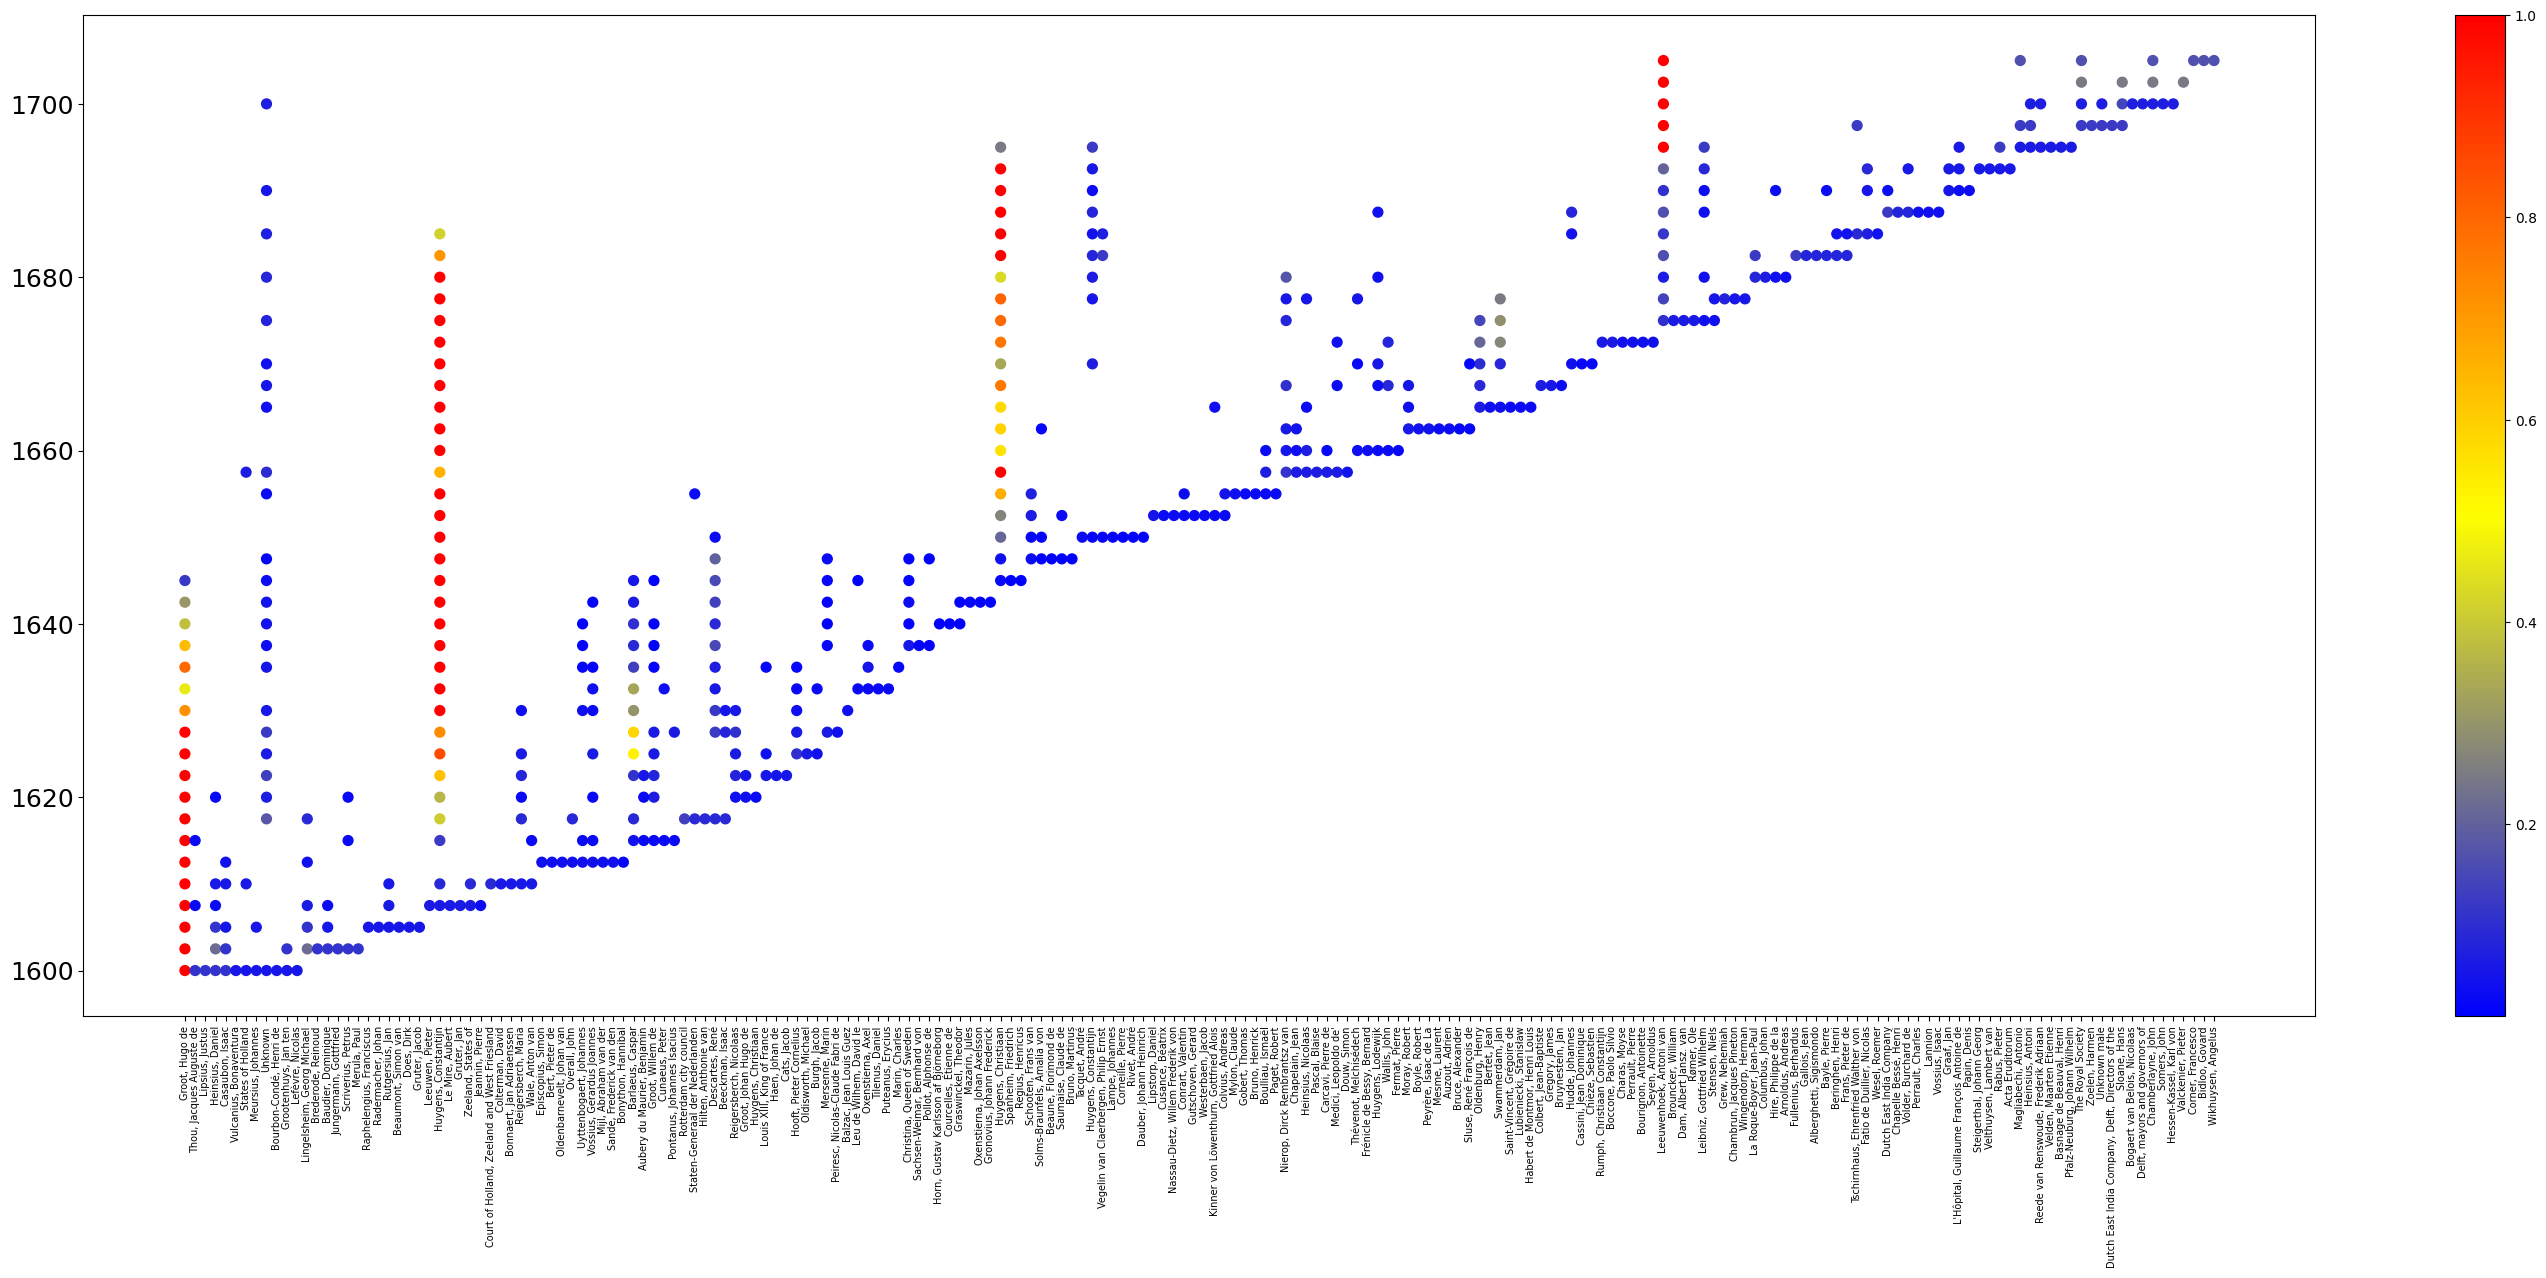

In [ ]:
'''
plot by degree value:
Y = year
X = actor index
Z/color = actor's rank at year Y
'''
YXZ = [(y, people_list.index(x), i) for y, arr in year_data.items() for x, i in arr.items()]
Y, X, colors = zip(*YXZ)

# set colorbar
colormap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["blue","yellow","red"])

# define the scatter plot
fig = plt.figure(figsize = [36.0, 13.0])
ax = fig.add_subplot()
sc = ax.scatter(X, Y, c = colors, cmap = colormap, s = 50.0)
plt.colorbar(sc)

# vertical actor labels below the plot
plt.xticks(ticks = [i for i,_ in enumerate(people_list)],
           labels = [people_lookup.get(x, '') for x in people_list],
           fontsize = 7,
           rotation = 90)

# size of years on y-axis
plt.yticks(fontsize = 18)

# save image
plt.savefig("Timeline_CKCC.png", dpi = None, transparent = False, bbox_inches = 'tight')

# show output
plt.show()
